In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Physical Constants
q = 1.6*10**(-19) #Coulombs
kTq = .0258 #Volts
ni2 = (9.7*10**9)**2 #10**20

#recombination coefficients
Cn = 9.9*10**(-32) #free particle
Cp = 2.8*10**(-31)
Cn0 = 1.8*10**(-24) #coulomb-enhanced
n0exp = 0.65
Cp0 = 6.0*10**(-25)
p0exp = 0.65
Cex = 3.0*10**(-27)
ex0exp = 0.8
Brad = 9.5*10**(-15) #radiative recombination constant

In [3]:
Spectrum = np.loadtxt(open("Spectrum.csv"), delimiter=",")
SiRI = np.loadtxt(open("silicon.csv"), delimiter=",")

In [ ]:
#ranges used in analysis
dopings = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/4.0+14.0)

In [148]:
#Various ways of calculation the Auger Recombination Rate
def Rauger(n,NB):
    p0 = ni2/NB
    #Pick one of these to uncomment for use - constants MUST be defined outside function
    Raug = n*((n+NB)*(Cn0*NB**n0exp+Cp0*p0**p0exp+Cex*n**ex0exp)) #n-type CE
    #Raug = n*(n+NB)*(Cn0*p0**n0exp+Cp0*NB**p0exp+Cex*n**ex0exp+Brad) #p-type CE(p0 is n0 because NB is ptype)
    #Raug = n*((n+NB)*(Cn0*NB**n0exp+Cp0*p0**p0exp+Cex*n**ex0exp+Brad)) #n-type includes radiative
    #Raug = Cn*((NB+n)**2)*n+Cp*(NB+n)*(n**2) #n-type free particle Auger
    #Raug = Cn*(NB+n)*(n**2)+Cp*((NB+n)**2)*n  #p-type free particle Auger
    #geeh = 1+(n/(3.0*10**18))**(-.35)  #correlation factors - this one is not complete
    #Raug = (Cn*geeh*(n)+Cp*geeh*(NB+n))*((NB+n)*n-ni2)
    return Raug

In [54]:
#for a given doping, Wb, and JL, find the maximum power point, corresponding voltage (under
#immediate extraction approximation) and maximum efficiency
#also find Voc - need to set "offset" to JL

def findVocMP(JL,Wb,NB):

    n = 10**17
    tolerance = .0001


    #finding Voc
    tauV = Wb*n*q/(JL)
    tauAuger = n/Rauger(n,NB)
    tauAvg = (tauV+tauAuger)/2.0
    tauErr = abs(tauV-tauAuger)/tauAvg
    while 1:
        if tauErr<=tolerance:
            break
        else:
            tauV = tauAvg
            nV = tauV*(JL)/(Wb*q)
            tauAuger = nV/Rauger(nV,NB)
            tauAvg = (tauV+tauAuger)/2.0
            tauErr = abs(tauV-tauAuger)/tauAvg
    nSet = tauAvg*(JL)/(Wb*q)

    Voc=kTq*log((nSet+NB)*nSet/(ni2))
    #VocLI = kTq*log(JL/(q*ni2*Cn0*NB*Wb))

    #finding MPP
    offset = .0001
    OP=0
    V=0

    while 1:
        offset = offset+0.0001
        tauV = Wb*n*q/(offset)
        tauAuger = n/Rauger(n,NB)
        tauAvg = (tauV+tauAuger)/2.0
        tauErr = abs(tauV-tauAuger)/tauAvg
        while 1:
            if tauErr<=tolerance:
                break
            else:
                tauV = tauAvg
                nV = tauV*(offset)/(Wb*q)
                tauAuger=  nV/Rauger(nV,NB)
                tauAvg = (tauV+tauAuger)/2.0
                tauErr = abs(tauV-tauAuger)/tauAvg
        nMPP = tauAvg*(offset)/(Wb*q)
        Voltage=kTq*log((nMPP+NB)*nMPP/(ni2))
        Power = (JL-offset)*Voltage
        if Power<=OP:
            break
        else:
            OP = Power
            V = Voltage

    return [Voc,OP,V]
   

In [55]:
#given a cell thickness, and a intesnsity as a number of suns, find the path length enhancement and total generation
#requires that SiRI is defined (silicon refractive index)
def findJL (Wb,suns):
    A=zeros(100)
    WL = zeros(100)
    Current = 0
    for a in range(0,100):
        wl = (250.0+a*10.0)*10**(-7) #cm from nm
        WL[a] = 250+a*10
        n = SiRI[a,1]
        k = SiRI[a,2]
        alpha = 4.0*pi*k/wl #cm-1
        
        #Various options
        #xw = 0.935*(alpha*Wb)**0.67 #(1)
        #WbLambertian = (2.0+xw)/(1.0+xw)*Wb #(1)
        #WbLambertian = Wb*4.0*(n**2) #cm (2)
        #Absorbtion = 1.0-exp(-1*alpha*WbLambertian) #(1,2)
        
        Absorbtion = alpha/(alpha+1/(4*n**2*Wb)) # (3) closest so far.
    
        A[a]=Absorbtion
        Current = Current+Spectrum[a,1]*q*Absorbtion*suns
    #can be uncommented to run this cell and plot absorption for the Wb below
    #plot(WL,A)
    #twinx()
    #plot(WL,Spectrum[0:100])
    return Current
#findJL(.0055,1.0)


Lifetime vs. Excess Carrier Density, and finding Voc and MPP

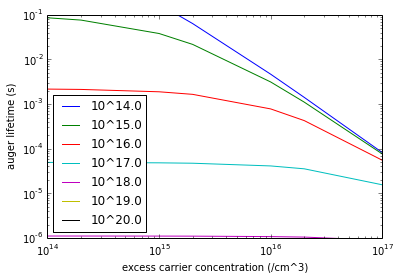

In [152]:
#Lifetime as a function of excess carrier density for a range of dopings 
#independent of thickness

deltans=[10**14,2*10**14,10**15,2*10**15,10**16,2*10**16,10**17]
dopings =[10**14,10**15,10**16,10**17,10**18,10**19,10**20]

taus = zeros(7)
for NB in dopings:
    ind = 0
    for n in deltans:
        taus[ind]=n/Rauger(n,NB)
        ind = ind+1
    lb = math.log10(NB)
    loglog(deltans,taus,label='10^'+str(lb))
ylim(10**-6,10**-1)
xlabel('excess carrier concentration (/cm^3)')
ylabel('auger lifetime (s)')
legend(loc='lower left')

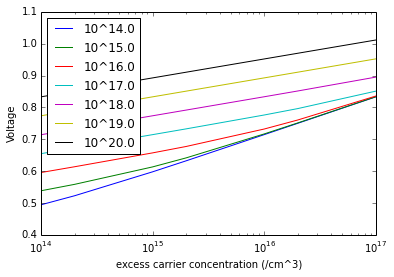

In [153]:
#simple relationship between carrier concentration and voltage.
#does not consider limits to do with Auger recombination 

deltans=[10**14,2*10**14,10**15,2*10**15,10**16,2*10**16,10**17]
dopings =[10**14,10**15,10**16,10**17,10**18,10**19,10**20]

vocs = zeros(7)
for NB in dopings:
    ind=0
    for n in deltans:
        ind = ind+1
        vocs[ind-1]=kTq*log((n+NB)*n/(ni2))
    lb = math.log10(NB)
    semilogx(deltans,vocs,label='10^'+str(lb))
    
legend(loc='upper left')
xlabel('excess carrier concentration (/cm^3)')
ylabel('Voltage')


To figure out what the open circuit voltage is, we consider that the recombination rate must be equal to the generation rate (=JL). The lifetime then determines how many carriers are in the device at a given time.  This can be imagined by considering a steady flow of carriers through a box of a certain length, where the flux into one end is the illumination current, and the flux out the other end is the recombination current.  Given a certain flux, or carrier velocity, a longer lifetime requires a longer box.  There are therefore more carriers in the device.  This box we've been imagining is not actually a physical space, but rather a metaphor for the path length of the carriers in the device.  We use the actual device thickness to determine the carrier density from the total number of carriers, and can therefore see that a longer lifetime leads to a higher carrier density (which we see above results in higher voltage)

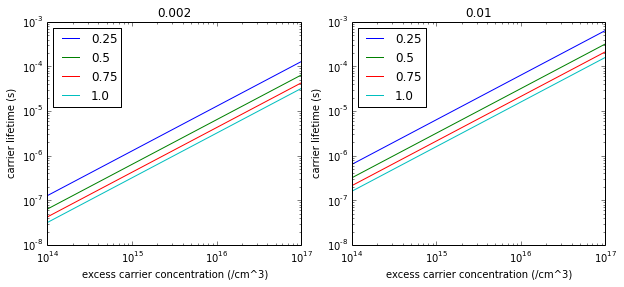

In [154]:
#Excess Carrier Concentration as a function of lifetime for the open circuit case 
#for different illumination intensities and device thicknesses

deltans=[10**14,2*10**14,10**15,2*10**15,10**16,2*10**16,10**17]
JLs = [.25,.5,.75,1.0]
figure(figsize=(10,4))
subplot(121)
Wb = 20*10**(-4)
tau=zeros(7)
for J in JLs:
    ind = 0
    for n in deltans:
        tau[ind] = Wb*n/(J/q)
        ind = ind+1
    loglog(deltans,tau,label=J)
xlabel('excess carrier concentration (/cm^3)')
ylabel('carrier lifetime (s)')
ylim(10**-8,10**-3)
legend(loc='upper left')
title(Wb)

subplot(122)
Wb = 100*10**(-4)
tau=zeros(7)
for J in JLs:
    ind = 0
    for n in deltans:
        tau[ind] = Wb*n/(J/q)
        ind = ind+1
    loglog(deltans,tau,label=J)
xlabel('excess carrier concentration (/cm^3)')
ylabel('carrier lifetime (s)')
ylim(10**-8,10**-3)
legend(loc='upper left')
title(Wb)

These steps can be combined to determine the Auger-Limited Voc for a device of a certain thickness and doping under a certain illumination - find the carrier concentration where the Auger limit for the doping intersects with the lifetime/carrier concentration at Voc for the illumination and device thickness.  Then find the Voc at this carrier concentration

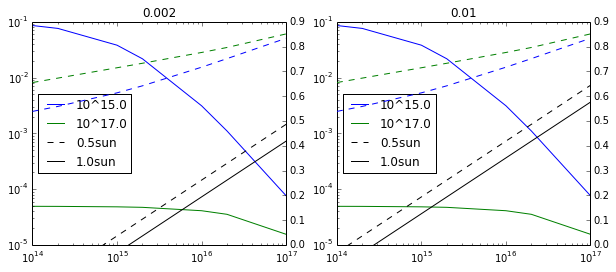

In [166]:
#Combined Graphs
basewidths=[20*10**(-4),100*10**(-4)]
dopings = [10**15,10**17]
JLs = [0.022,.044]
JLstyle = ['dashed','solid']
deltans=[10**14,2*10**14,10**15,2*10**15,10**16,2*10**16,10**17]

figure(figsize=(10,4))
bw=1
for Wb in basewidths:
    subplot(1,2,bw)
    bw=bw+1
    
    taus = zeros(7)
    for NB in dopings:
        ind = 0
        for n in deltans:
            taus[ind]=n/Rauger(n,NB)
            ind = ind+1
        loglog(deltans,taus,label='10^'+str(math.log10(NB)))
    ylim(10**-5,10**-1)
    

    tauV=zeros(7)
    jind=0
    for J in JLs:
        ind = 0
        for n in deltans:
            tauV[ind] = Wb*n/(J/q)
            ind = ind+1
        loglog(deltans,tauV,'black',ls=JLstyle[jind],label=str(.5+.5*jind)+'sun')
        jind=jind+1
    legend(loc='center left')
        
    twinx() 
    vocs = zeros(7)
    for NB in dopings:
        ind=0
        for n in deltans:
            ind = ind+1
            vocs[ind-1]=kTq*log((n+NB)*n/(ni2))
        semilogx(deltans,vocs,ls='dashed')
    ylim(0.0,0.9)
    title(Wb)
    
#subplot(121)
#axvline(4.3*10**(16),ls='dotted')
#axvline(5.8*10**(15),ls='dotted')
    #xlabel('excess carrier concentration(/cm^3)')
    #ylabel('Voc')


Using these processes to determine optimal dopings and thicknesses and limiting efficiencies under certain illuminations.

The maximum power point is modeled by assuming that carriers which contribute to the current are immediately extracted from the device. We then calculate the limiting voltage under a recombination current of JL-extracted current ("offset") in the code. The extracted power is (extracted current)x(limiting voltage)

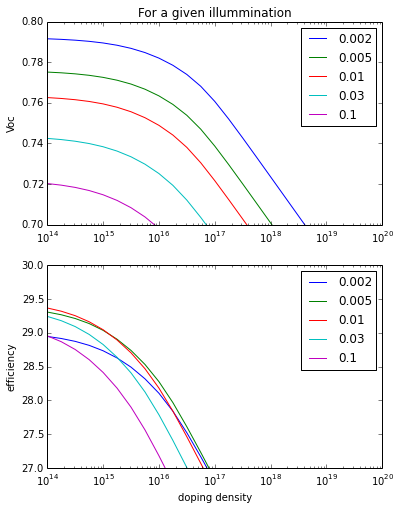

In [167]:
#Voc and Efficiency limits for a given suns
sun = 1.0

dopings = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/4.0+14.0)

con=10**(-4)
Wbs = [20.0*con,50.0*con,100.0*con,300.0*con,1000.0*con]

vocs=zeros(25)
effs=zeros(25)
figure(figsize=(6,8))
for w in Wbs:
    ind = 0
    for d in dopings:
        JL=findJL(w,sun)
        [Voc,Eff,v]=findVocMP(JL,w,d)
        vocs[ind]=Voc
        effs[ind]=Eff/(sun*.001)
        ind = ind+1
    subplot(211)
    semilogx(dopings,vocs,label=w)
    subplot(212)
    semilogx(dopings,effs,label=w)
subplot(211)
ylabel("Voc")
ylim(0.7,0.8)
legend(loc='upper right')
title("For a given illummination")
subplot(212)
ylabel("efficiency")
ylim(27,30)
xlabel("doping density")
legend(loc='upper right')
   

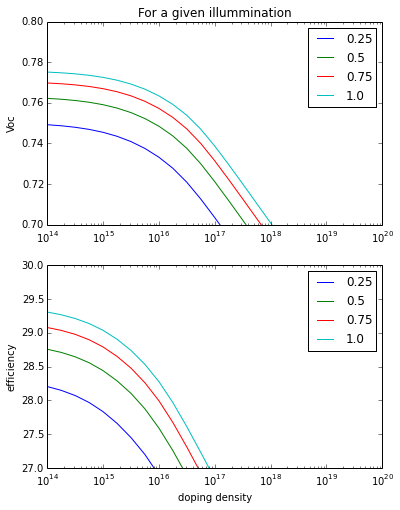

In [168]:
#Voc and Efficiency limits for a given base thickness
Wb = 50*10**(-4) #cm from um

dopings = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/4.0+14.0)


suns = [0.25,0.5,0.75,1.0]

vocs=zeros(25)
effs=zeros(25)
figure(figsize=(6,8))
for s in suns:
    ind = 0
    for d in dopings:
        JL=findJL(Wb,s)
        [Voc,Eff,v]=findVocMP(JL,Wb,d)
        vocs[ind]=Voc
        effs[ind]=Eff/(s*.001)
        ind = ind+1
    subplot(211)
    semilogx(dopings,vocs,label=s)
    subplot(212)
    semilogx(dopings,effs,label=s)
subplot(211)
ylabel("Voc")
ylim(0.7,0.8)
legend(loc='upper right')
title("For a given illummination")
subplot(212)
ylabel("efficiency")
ylim(27,30)
xlabel("doping density")
legend(loc='upper right')
   

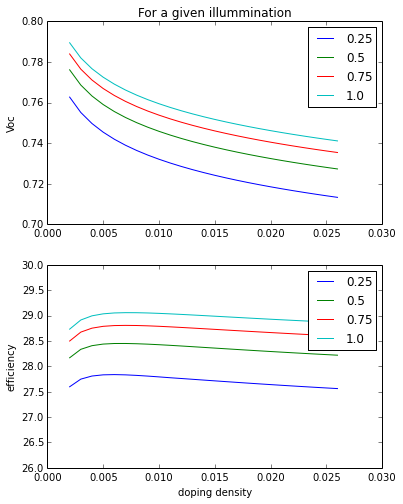

In [169]:
#Voc and Efficiency limits for a given dopin
NB = 10**15 #cm from um

dopings = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/4.0+14.0)

con=10**(-4)
suns = [0.25,0.5,0.75,1.0]
Wbs=zeros(25)
for w in range(0,25):
    Wbs[w]=(10*w+20)*10**(-4)

vocs=zeros(25)
effs=zeros(25)
figure(figsize=(6,8))
for s in suns:
    ind = 0
    for w in Wbs:
        JL=findJL(w,s)
        [Voc,Eff,v]=findVocMP(JL,w,NB)
        vocs[ind]=Voc
        effs[ind]=Eff/(s*.001)
        ind = ind+1
    subplot(211)
    plot(Wbs,vocs,label=s)
    subplot(212)
    plot(Wbs,effs,label=s)
subplot(211)
ylabel("Voc")
ylim(0.7,0.8)
legend(loc='upper right')
title("For a given illummination")
subplot(212)
ylabel("efficiency")
ylim(26,30)
xlabel("doping density")
legend(loc='upper right')
   

In [170]:
#Voc and Efficiency limits and optimal designs for a given sun
sun = 0.5

dopings = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/4.0+14.0)

Wbs = zeros(25)
for w in range(0,25):
    Wbs[w]=(10*w+20)*10**(-4)

vocs=zeros(25)
effs=zeros(25)
bestE = 0
for w in Wbs:
    ind = 0
    for d in dopings:
        JL=findJL(w,sun)
        [Voc,Eff,v]=findVocMP(JL,w,d)
        vocs[ind]=Voc
        effs[ind]=Eff/(sun*.001)
        ind = ind+1
    bestEthisW = max(effs)
    bestDopingthisW = dopings[argmax(effs)]
    if bestEthisW > bestE:
        bestDoping = bestDopingthisW
        bestE = bestEthisW
        bestWidth = w
        
print 'Best Efficiency'
print bestE
print 'Best Doping'
print bestDoping
print 'Best Width'
print bestWidth*10**4

Best Efficiency
28.8042935242
Best Doping
1e+14
Best Width
90.0


In [171]:
#Voc and Efficiency limits and optimal designs for a range of suns and performance for other suns
suns = [0.5,0.6,0.7,0.8,0.9,1.0]
bestDs = zeros(6)
bestWs = zeros(6)

dopings = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/10.0+14.0)
#dopings[0] = 1.5*10.0**16.0
Wbs = zeros(25)
for w in range(0,25):
    Wbs[w]=(2*w+70)*10**(-4)
    
sind = 0    
for s in suns:
    vocs=zeros(25)
    effs=zeros(25)
    bestE = 0
    for w in Wbs:
        ind = 0
        for d in dopings:
            JL=findJL(w,s)
            [Voc,Eff,v]=findVocMP(JL,w,d)
            vocs[ind]=Voc
            effs[ind]=Eff/(s*.001)
            ind = ind+1
        bestEthisW = max(effs)
        bestDopingthisW = dopings[argmax(effs)]
        if bestEthisW > bestE:
            bestDoping = bestDopingthisW
            bestE = bestEthisW
            bestWidth = w
    bestDs[sind]=bestDoping
    bestWs[sind]=bestWidth
    sind = sind+1
print dopings        
print bestDs
print bestWs



[  1.00000000e+14   1.25892541e+14   1.58489319e+14   1.99526231e+14
   2.51188643e+14   3.16227766e+14   3.98107171e+14   5.01187234e+14
   6.30957344e+14   7.94328235e+14   1.00000000e+15   1.25892541e+15
   1.58489319e+15   1.99526231e+15   2.51188643e+15   3.16227766e+15
   3.98107171e+15   5.01187234e+15   6.30957344e+15   7.94328235e+15
   1.00000000e+16   1.25892541e+16   1.58489319e+16   1.99526231e+16
   2.51188643e+16]
[  1.00000000e+14   1.00000000e+14   1.00000000e+14   1.00000000e+14
   1.00000000e+14   1.00000000e+14]
[ 0.0088  0.009   0.009   0.0092  0.0094  0.0096]


<matplotlib.colorbar.Colorbar instance at 0x7f6f40a7a050>

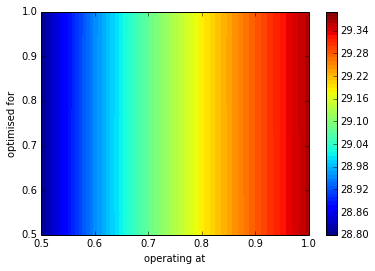

In [172]:
#2d plot of effieciency limit

efficiencies = zeros([6,6])

sind = 0
for s in suns:
    rind=0
    for r in suns:
        JL= findJL(bestWs[sind],r)
        [Voc,Eff,v]=findVocMP(JL,bestWs[sind],bestDs[sind])
        efficiencies[sind,rind]=Eff/(r*.001)
        rind = rind+1
    sind = sind+1
contourf(suns,suns,efficiencies,np.arange(28.8,29.4,.01))
xlabel('operating at')
ylabel('optimised for')
colorbar()

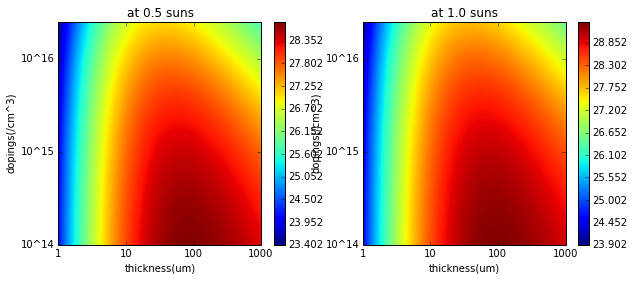

In [173]:
### Efficiency 2-d plots for a given illumination
suns = [0.5,1.0]
Nsuns = 2
figure(figsize=(10,4))

dopings = zeros(25)
dlog = zeros(25)
for d in range(0,25):
    dopings[d]=10.0**(d/10.0+14.0)
    dlog[d]=(d/10.0+14.0)
#dopings[0] = 1.5*10.0**16.0
Wbs = zeros(25)
wlog = zeros(25)
for w in range(0,25):
    #Wbs[w]=(10*w+20)*10**(-4)
    Wbs[w]=10**(w/8.0-4.0)
    wlog[w]=w/8.0
    
efficiencies = zeros([25,25])

sind = 1
for s in suns:
    dind=0
    for d in dopings:
        wind = 0
        for w in Wbs:
            JL= findJL(w,s)
            [Voc,Eff,v]=findVocMP(JL,w,d)
            efficiencies[dind,wind]=Eff/(s*.001)
            wind = wind+1
        dind = dind+1
    
    subplot(1,2,sind)
    sind = sind+1
    low = amin(efficiencies)
    high = amax(efficiencies)+.01
    contourf(wlog,dlog,efficiencies,np.arange(low,high,.01))
    title('at '+str(s)+' suns')
    ylabel('dopings(/cm^3)')
    xlabel('thickness(um)')
    xticks([0,1,2,3],[1,10,100,1000])
    yticks([14,15,16],['10^14','10^15','10^16'])
    colorbar()


In [124]:
print amax(efficiencies)

29.3660656314
